# Detect AI vs Human generated images
In this notebook, I aim to build a convnet architecture for detecting real images from fake ones.

In [1]:
# All imports needed for this classification project
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet152, Xception
from tensorflow.keras.applications.resnet import preprocess_input

In [2]:
# Global variables 
IMG_SIZE = 224

# Reproducability
def set_seed(seed=44):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [3]:
# Download latest version
data_path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", data_path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [4]:
# Csv files
train = pd.read_csv(os.path.join(data_path,"train.csv"), index_col=0)
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [5]:
print(train.head())

                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [6]:
# Create full path to the images
train["file_name"] = train["file_name"].apply(lambda image_path: os.path.join(data_path, image_path))

# Below list is created to avoid altering test dataframe
test_full_path  = [os.path.join(data_path, image_path) for image_path in test["id"]]

In [7]:
# Split train into train and validation data
train_ds, val_ds = train_test_split(train, test_size=0.2, random_state=44)
train_ds = tf.data.Dataset.from_tensor_slices((train_ds["file_name"].tolist(), train_ds["label"]))
val_ds = tf.data.Dataset.from_tensor_slices((val_ds["file_name"].tolist(), val_ds["label"]))

In [8]:
def load_and_resize(image_path, label=None):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = preprocess_input(image)
    
    if label is None:
        return image
        
    return image, label

In [9]:
def augment(image_label, seed):
  image, label = image_label
  image, label = load_and_resize(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [10]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds_counter = tf.data.Dataset.zip((train_ds, (counter, counter)))
batch_size = 32

In [11]:
train_org = (
    train_ds
    .shuffle(1000)
    .map(load_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

train_aug = (
    train_ds_counter
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

train_ds = train_org.concatenate(train_aug)

In [12]:
val_ds = (
    val_ds
    .map(load_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
pretrained_base = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
avg = keras.layers.GlobalAveragePooling2D()(pretrained_base.output)
output = keras.layers.Dense(2, activation="softmax")(avg)
model = keras.models.Model(inputs=pretrained_base.input, outputs=output)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [14]:
for layer in pretrained_base.layers:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
history = model.fit(train_ds,
                    steps_per_epoch=int(0.75 * len(train_ds) / batch_size),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * len(train_ds) / batch_size),
                    epochs=5, 
                    verbose=1)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - accuracy: 0.7318 - loss: 0.5573 - val_accuracy: 0.7830 - val_loss: 0.4684
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8078 - loss: 0.4556 - val_accuracy: 0.7865 - val_loss: 0.4446
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8135 - loss: 0.4315 - val_accuracy: 0.8003 - val_loss: 0.4448
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.8009 - loss: 0.4474 - val_accuracy: 0.8160 - val_loss: 0.4274
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.8023 - loss: 0.4353 - val_accuracy: 0.8056 - val_loss: 0.4369


In [15]:
for layer in pretrained_base.layers:
    layer.trainable = True

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
history = model.fit(train_ds,
                    steps_per_epoch=int(0.75 * len(train_ds) / batch_size),
                    validation_data=val_ds,
                    validation_steps=int(0.15 * len(train_ds) / batch_size),
                    epochs=5, 
                    verbose=1)

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 194s 509ms/step - accuracy: 0.7121 - loss: 1.1976 - val_accuracy: 0.5226 - val_loss: 533163.7500
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 404ms/step - accuracy: 0.8017 - loss: 0.4301 - val_accuracy: 0.5156 - val_loss: 0.9519
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 401ms/step - accuracy: 0.8979 - loss: 0.2901 - val_accuracy: 0.5104 - val_loss: 1.4521
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 401ms/step - accuracy: 0.8987 - loss: 0.2649 - val_accuracy: 0.5052 - val_loss: 3.9589
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step - accuracy: 0.8643 - loss: 0.3423 - val_accuracy: 0.4861 - val_loss: 1.9425


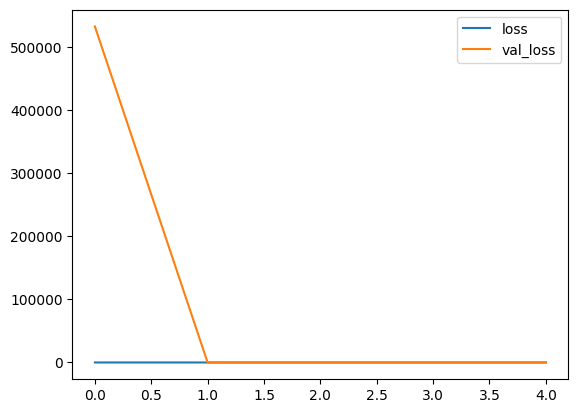

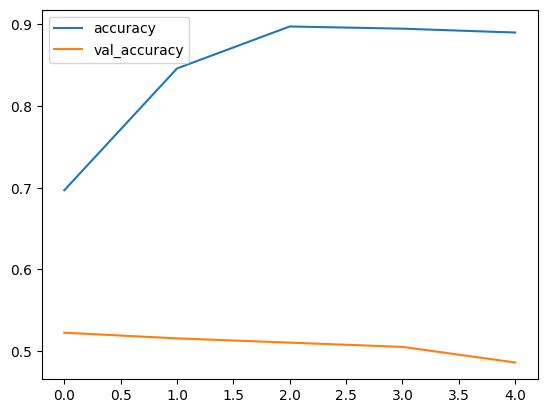

In [16]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [17]:
test_data = tf.data.Dataset.from_tensor_slices(test_full_path)
test_data = test_data.map(load_resize_and_rescale, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
pred = model.predict(test_data)

174/174 ━━━━━━━━━━━━━━━━━━━━ 68s 346ms/step


In [19]:
ar = [0 if i > 0.5 else 1 for i,j in pred]

In [20]:
test["label"] = ar
test.to_csv("predictions.csv", index=False)

In [21]:
print(ar)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 